# Final Project – MSCS 634

Student: Bhawesh Shrestha

This notebook consolidates all project phases and results.

- Dataset description  
- Data preprocessing & EDA  
- Regression, classification, clustering, and association rule mining  
- Insights, recommendations, and ethical considerations  


In [40]:
# =========================
# 1. Imports and Configuration
# =========================

# Core
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso

# Classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, roc_auc_score, classification_report
)

# Clustering
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

# Association Rules
from mlxtend.frequent_patterns import apriori, association_rules

# Settings
plt.style.use("default")
pd.set_option("display.max_columns", None)


## Dataset Description
Describe the dataset and source here.


In [41]:
import pandas as pd
import numpy as np
import os

OUTPUT_DIR = "outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# --- Configure local data paths (no internet required)
EXCEL_PATH = "Online Retail.xlsx"   # Put the UCI Excel file here
CSV_PATH   = None                   # Or point to a CSV if you have one

# --- Load dataset (prefer Excel if present)
if CSV_PATH and os.path.exists(CSV_PATH):
    df_raw = pd.read_csv(CSV_PATH)
elif os.path.exists(EXCEL_PATH):
    # UCI original Excel file uses the first sheet
    df_raw = pd.read_excel(EXCEL_PATH, sheet_name=0, engine="openpyxl")
else:
    raise FileNotFoundError(
        "Data file not found."
        "Place 'Online Retail.xlsx' beside this notebook or set CSV_PATH to a valid CSV file path."
    )

# --- Basic cleaning consistent with Deliverable 1
df = df_raw.copy()

## Data Preprocessing
Include cleaning steps and initial visualizations.

    -Missing value handling

    -Filtering (e.g., removing returns, negative quantities)

    -Creating new columns (e.g., TotalPrice = Quantity * UnitPrice)

EDA visualizations:

    -distributions

    -sales by country

    -top customers/products

    -correlation heatmaps


In [42]:
try:
    df = df_raw.copy()

    # Basic type fixes
    if "InvoiceDate" in df.columns:
        df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], errors="coerce")
    if "Quantity" in df.columns:
        df["Quantity"] = pd.to_numeric(df["Quantity"], errors="coerce")
    if "UnitPrice" in df.columns:
        df["UnitPrice"] = pd.to_numeric(df["UnitPrice"], errors="coerce")

    # Remove exact duplicates
    before = df.shape[0]
    df = df.drop_duplicates()
    after = df.shape[0]
    print(f"Removed {before - after} duplicate rows.")

    # Add TotalPrice
    if all(col in df.columns for col in ["Quantity", "UnitPrice"]):
        df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]

    # Cleaned copy with customer IDs only (for user-level analysis)
    df_cust = df.dropna(subset=["CustomerID"]).copy()
    df_cust["CustomerID"] = df_cust["CustomerID"].astype(str).str.strip()

    # Sales-only subset (exclude returns)
    df_sales = df[df["Quantity"] > 0].copy()

    # Quick sanity checks
    print("Original shape:", df_raw.shape)
    print("Cleaned shape:", df.shape)
    print("With CustomerID shape:", df_cust.shape)
    print("Sales-only shape:", df_sales.shape)

    # Preview
    display(df.head())
except NameError:
    print("Please load df_raw in Section 1 before running this cell.")


Removed 5268 duplicate rows.
Original shape: (541909, 8)
Cleaned shape: (536641, 9)
With CustomerID shape: (401604, 9)
Sales-only shape: (526054, 9)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


## Exploratory Data Analysis (EDA)
We’ll explore distributions, top contributors, time trends, and relationships.

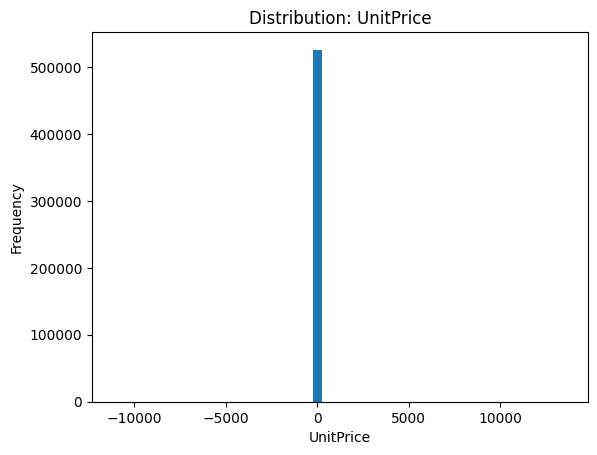

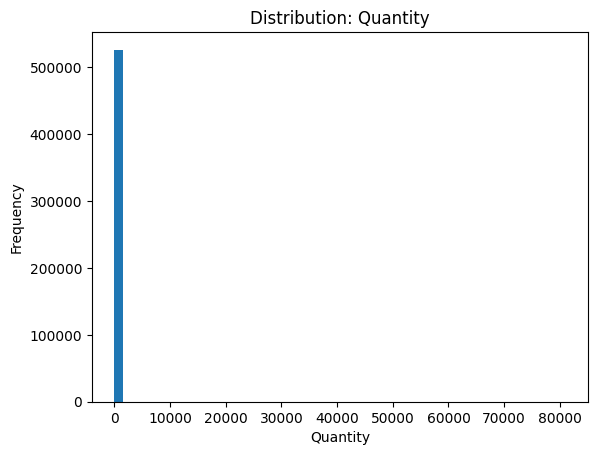

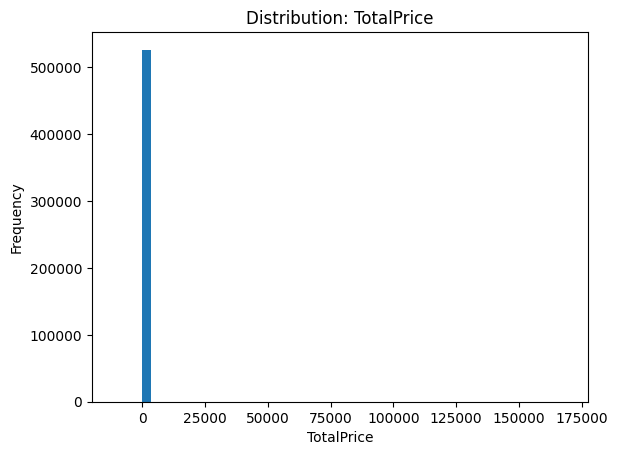

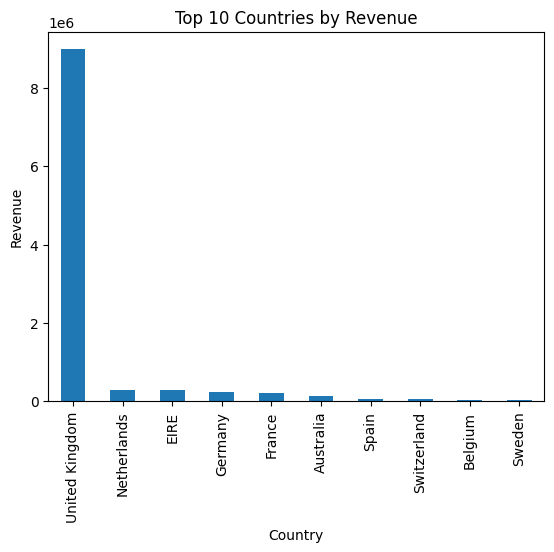

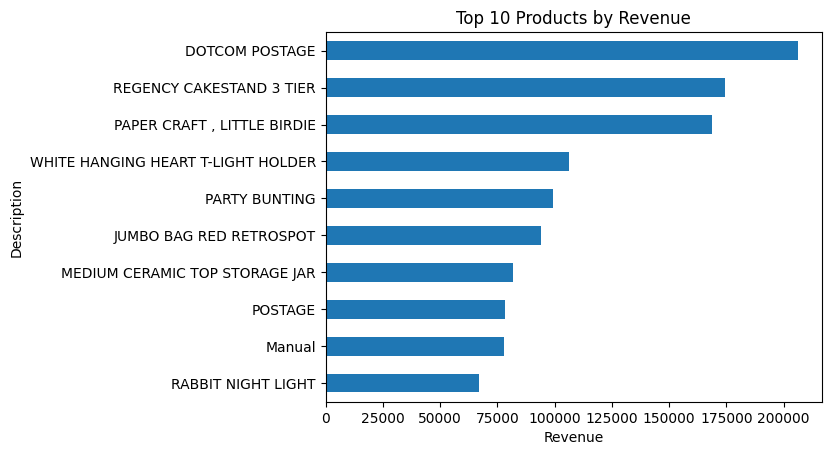

C:\Users\bhawe\AppData\Local\Temp\ipykernel_2092\2447784821.py:50: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M")["TotalPrice"]


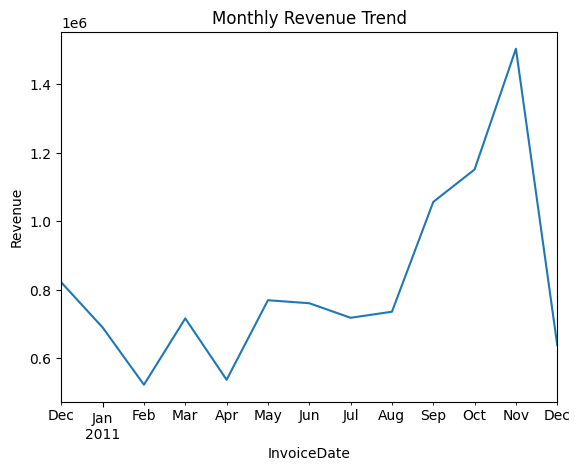

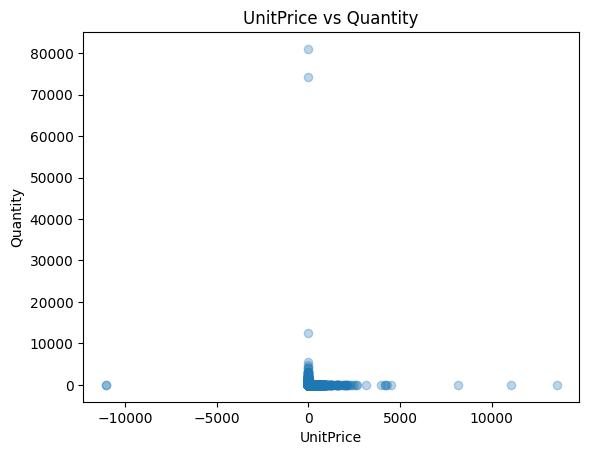

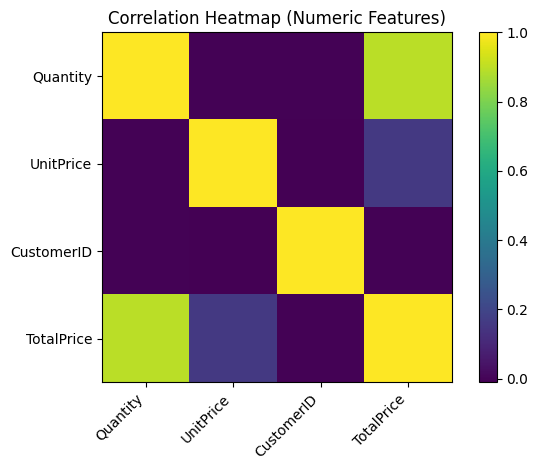

In [43]:
try:
    import matplotlib.pyplot as plt

    # 5.1 Distributions
    fig = plt.figure()
    df_sales["UnitPrice"].dropna().plot(kind="hist", bins=50, title="Distribution: UnitPrice")
    plt.xlabel("UnitPrice")
    plt.show()

    fig = plt.figure()
    df_sales["Quantity"].dropna().plot(kind="hist", bins=50, title="Distribution: Quantity")
    plt.xlabel("Quantity")
    plt.show()

    fig = plt.figure()
    df_sales["TotalPrice"].dropna().plot(kind="hist", bins=50, title="Distribution: TotalPrice")
    plt.xlabel("TotalPrice")
    plt.show()

    # 5.2 Top countries by revenue
    top_countries = (
        df_sales.groupby("Country")["TotalPrice"]
        .sum()
        .sort_values(ascending=False)
        .head(10)
    )
    fig = plt.figure()
    top_countries.plot(kind="bar", title="Top 10 Countries by Revenue")
    plt.ylabel("Revenue")
    plt.show()

    # 5.3 Top products by revenue
    if "Description" in df_sales.columns:
        top_products = (
            df_sales.groupby("Description")["TotalPrice"]
            .sum()
            .sort_values(ascending=False)
            .head(10)
        )
        fig = plt.figure()
        top_products.plot(kind="barh", title="Top 10 Products by Revenue")
        plt.xlabel("Revenue")
        plt.gca().invert_yaxis()
        plt.show()

    # 5.4 Monthly revenue trend
    if "InvoiceDate" in df_sales.columns:
        monthly = (
            df_sales.set_index("InvoiceDate")
            .resample("M")["TotalPrice"]
            .sum()
        )
        fig = plt.figure()
        monthly.plot(title="Monthly Revenue Trend")
        plt.ylabel("Revenue")
        plt.show()

    # 5.5 Relationship: UnitPrice vs Quantity
    fig = plt.figure()
    plt.scatter(df_sales["UnitPrice"], df_sales["Quantity"], alpha=0.3)
    plt.title("UnitPrice vs Quantity")
    plt.xlabel("UnitPrice")
    plt.ylabel("Quantity")
    plt.show()

    # 5.6 Correlation heatmap (numeric)
    numeric = df_sales.select_dtypes(include=[np.number])
    corr = numeric.corr()
    fig = plt.figure()
    plt.imshow(corr, interpolation="nearest")
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha="right")
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.colorbar()
    plt.title("Correlation Heatmap (Numeric Features)")
    plt.tight_layout()
    plt.show()

except NameError:
    print("Please finish cleaning steps first.")

## Modeling Results
Regression, Classification, and Clustering models summary.


## Regression Models

We compare **at least two** models (and include a few more for completeness):

- **LinearRegression**: baseline multiple linear regression (no regularization)
- **RidgeCV**: L2-regularized regression with built-in cross-validated alpha
- **LassoCV**: L1-regularized regression (feature selection) with CV alpha
- **ElasticNetCV**: balance of L1 & L2 regularization with CV (often robust)

We optionally train with a **log-transformed target** (`log1p`) to handle revenue skew and improve RMSE stability.

We use **5-fold CV** with:
- **R²** (higher is better)
- **RMSE** (lower is better)

Then we fit on the **training split** and evaluate on the **held-out test split**.
Finally, we **export** a metrics table to `screenshots/metrics_table.csv` for your submission.

We produce three submission-friendly plots and save them under `/screenshots`:

1. **Test R² bar chart** across models  
2. **Actual vs Predicted** for the best model on the test set  
3. **Residuals vs Predicted** for the best model (to check patterns)

Share of return lines: 1.96 %
Share of cancelled invoices: 1.71 %
Prepared invoice-level dataset shape: (20728, 11)
After cleaning target:
X shape: (19960, 9) y shape: (19960,)
Min y: 0.38 Max y: 168469.6
Train shape: (15968, 9) Test shape: (3992, 9)


,Model,CV_R2_Mean,CV_R2_STD,CV_RMSE_Mean,CV_RMSE_STD,Test_R2,Test_RMSE
1,RidgeCV,-1.158911e+20,2.317401e+20,1.585430e+13,3.143449e+13,-1.040962e+06,8.754681e+05
3,ElasticNetCV,-7.357033e+14,1.469808e+15,4.033223e+10,7.898145e+10,-1.951858e+06,1.198800e+06
2,LassoCV,-1.580096e+08,3.130743e+08,1.924198e+07,3.621420e+07,-2.898855e+06,1.460952e+06
0,LinearRegression,-2.072180e+21,4.144055e+21,6.687379e+13,1.330101e+14,-4.068947e+06,1.730867e+06


Saved metrics to screenshots/metrics_table.csv


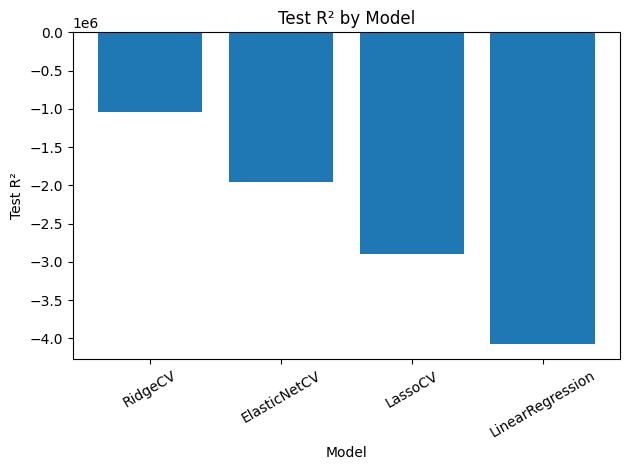

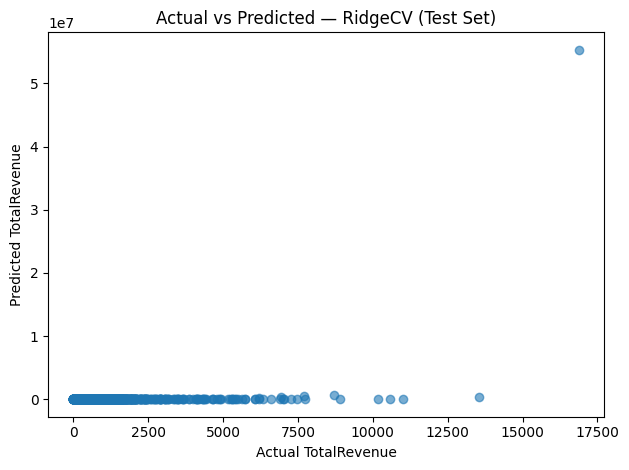

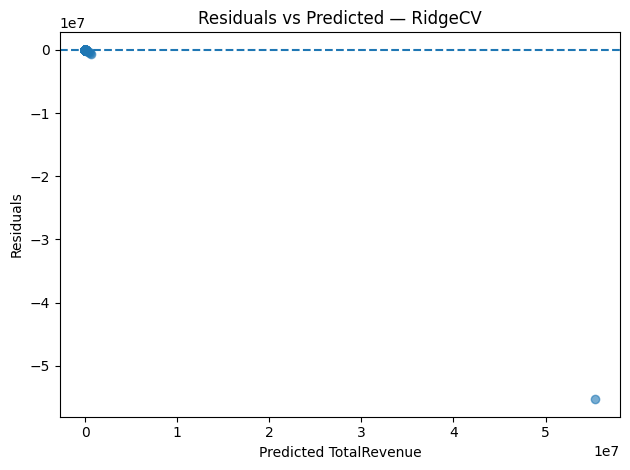

In [44]:

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import (
    LinearRegression,
    RidgeCV,
    LassoCV,
    ElasticNetCV
)
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor



# --- Basic cleaning consistent with Deliverable 1
# Coerce types safely (errors='coerce' turns bad parses to NaN)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')
for col in ['Quantity', 'UnitPrice']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop exact duplicate rows (we could also specify a subset of columns)
df = df.drop_duplicates()

# --- Basic cleaning consistent with Deliverable 1 (drop rows with missing critical fields)
df = df_raw.copy()
df = df.dropna(subset=['InvoiceNo', 'InvoiceDate', 'Quantity', 'UnitPrice', 'Country'])

# Compute line-level total price
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']


# Compute line-level total price
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Identify returns and cancellations (for transparency / logging)
is_return = df['Quantity'] < 0
is_cancel = df['InvoiceNo'].astype(str).str.startswith('C', na=False)
print("Share of return lines:", round(is_return.mean()*100, 2), "%")
print("Share of cancelled invoices:", round(is_cancel.mean()*100, 2), "%")

# Keep strictly sales-only lines (no returns, no cancellations)
df_sales = df[(df['Quantity'] > 0) & (~is_cancel)].copy()

# --- Aggregate to invoice-level for regression target
# We will predict TotalRevenue per invoice.
invoice_agg = (
    df_sales.groupby(['InvoiceNo', 'Country'], as_index=False)
            .agg(
                InvoiceDate=('InvoiceDate', 'min'),            # invoice timestamp
                ItemCount=('Quantity', 'sum'),                 # total quantity
                UniqueItems=('StockCode', 'nunique'),          # distinct SKUs
                AvgUnitPrice=('UnitPrice', 'mean'),            # average price
                TotalRevenue=('TotalPrice', 'sum')             # *** target ***
            )
)

# --- Time-based features
invoice_agg['InvoiceYear']  = invoice_agg['InvoiceDate'].dt.year
invoice_agg['InvoiceMonth'] = invoice_agg['InvoiceDate'].dt.month
invoice_agg['InvoiceDay']   = invoice_agg['InvoiceDate'].dt.day
invoice_agg['InvoiceDow']   = invoice_agg['InvoiceDate'].dt.dayofweek
invoice_agg['InvoiceHour']  = invoice_agg['InvoiceDate'].dt.hour

# We no longer need the raw datetime for modeling
invoice_agg = invoice_agg.drop(columns=['InvoiceDate'])

print("Prepared invoice-level dataset shape:", invoice_agg.shape)
invoice_agg.head()

# --- Define target
target_col = "TotalRevenue"
y = invoice_agg[target_col].values

# --- Select features
numeric_features = [
    'ItemCount', 'UniqueItems', 'AvgUnitPrice',
    'InvoiceYear', 'InvoiceMonth', 'InvoiceDay',
    'InvoiceDow', 'InvoiceHour'
]
categorical_features = ['Country']

X = invoice_agg[numeric_features + categorical_features]

# --- Train/test split (hold-out for final evaluation)
# --- Clean target: remove NaNs and non-positive values if using log transform
# Features for the model
X = invoice_agg[numeric_features + categorical_features]

# --- Clean target: remove NaNs and non-positive values if using log transform
y = invoice_agg["TotalRevenue"].to_numpy()

mask = ~np.isnan(y)
if LOG_TARGET:
    mask &= (y > 0)   # log1p only for positive revenue

# Apply mask to both X and y
X = X.loc[mask].copy()
y = y[mask]

print("After cleaning target:")
print("X shape:", X.shape, "y shape:", y.shape)
print("Min y:", y.min(), "Max y:", y.max())

# --- Train/test split (hold-out for final evaluation)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


# --- Numeric pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',  StandardScaler(with_mean=True, with_std=True))
])

# --- Categorical pipeline
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot',  OneHotEncoder(handle_unknown='ignore'))
])

# --- Combine into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)


# --- Choose whether to use log-transform on the target
LOG_TARGET = True  # set to False to train on raw revenue

# --- Define base estimators
base_models = {
    'LinearRegression': LinearRegression(),
    'RidgeCV':   RidgeCV(alphas=np.logspace(-3, 3, 21), cv=5),
    'LassoCV':   LassoCV(alphas=np.logspace(-3, 1, 20), cv=5, max_iter=10000, random_state=42),
    'ElasticNetCV': ElasticNetCV(l1_ratio=[.1,.3,.5,.7,.9], alphas=np.logspace(-3, 1, 20),
                                 cv=5, max_iter=10000, random_state=42)
}

# --- Build preprocessing + model pipeline.
# If LOG_TARGET is True, wrap the pipeline with TransformedTargetRegressor for log1p/expm1.
pipelines = {}
for name, model in base_models.items():
    pipe = Pipeline(steps=[('preprocess', preprocessor),
                          ('model', model)])
    if LOG_TARGET:
        # Transform y via log1p during training and inverse-transform via expm1 on predict
        t_pipe = TransformedTargetRegressor(
            regressor=pipe,
            func=np.log1p,         # y -> log1p(y)
            inverse_func=np.expm1  # y_pred -> expm1(y_pred)
        )
        pipelines[name] = t_pipe
    else:
        pipelines[name] = pipe

list(pipelines.keys())


# --- 5-fold CV config
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# --- Helpers to get CV scores for R2 and RMSE
def cv_scores(pipe, X, y):
    # cross_val_score expects a plain estimator; TransformedTargetRegressor works too
    r2 = cross_val_score(pipe, X, y, cv=kfold, scoring='r2')
    # Negative MSE (maximize) -> convert to RMSE
    neg_mse = cross_val_score(pipe, X, y, cv=kfold, scoring='neg_mean_squared_error')
    rmse = np.sqrt(-neg_mse)
    return r2, rmse

# --- Train/Evaluate all models
cv_results = []
fitted = {}

for name, est in pipelines.items():
    # 1) Cross-validation on TRAIN data
    r2_cv, rmse_cv = cv_scores(est, X_train, y_train)

    # 2) Fit on full TRAIN split
    est.fit(X_train, y_train)
    fitted[name] = est

    # 3) Evaluate on TEST split
    y_pred_test = est.predict(X_test)
    # Ensure no negative predictions after inverse-transform (rare but possible)
    y_pred_test = np.maximum(y_pred_test, 0.0)

    test_r2   = r2_score(y_test, y_pred_test)
    test_mse  = mean_squared_error(y_test, y_pred_test)
    test_rmse = np.sqrt(test_mse)

    cv_results.append({
        'Model': name,
        'CV_R2_Mean':   np.mean(r2_cv),
        'CV_R2_STD':    np.std(r2_cv),
        'CV_RMSE_Mean': np.mean(rmse_cv),
        'CV_RMSE_STD':  np.std(rmse_cv),
        'Test_R2':      test_r2,
        'Test_RMSE':    test_rmse
    })

# --- Summarize results
cv_df = pd.DataFrame(cv_results).sort_values(by='Test_R2', ascending=False)
display(cv_df)

# --- Save the metrics table for your repo screenshots
os.makedirs("screenshots", exist_ok=True)
cv_df.to_csv("screenshots/metrics_table.csv", index=False)
print("Saved metrics to screenshots/metrics_table.csv")


# 6.1: Test R² bar chart
plt.figure()
plt.bar(cv_df['Model'], cv_df['Test_R2'])
plt.title('Test R² by Model')
plt.xlabel('Model')
plt.ylabel('Test R²')
plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig('screenshots/test_r2_bar.png', dpi=160)
plt.show()

# Identify best model by Test_R2
best_name = cv_df.iloc[0]['Model']
best_est  = fitted[best_name]

# Predict on test for plots
y_pred = best_est.predict(X_test)
y_pred = np.maximum(y_pred, 0.0)

# 6.2: Actual vs Predicted
plt.figure()
plt.scatter(y_test, y_pred, alpha=0.6)
plt.title(f'Actual vs Predicted — {best_name} (Test Set)')
plt.xlabel('Actual TotalRevenue')
plt.ylabel('Predicted TotalRevenue')
plt.tight_layout()
plt.savefig('screenshots/actual_vs_pred.png', dpi=160)
plt.show()

# 6.3: Residuals vs Predicted
residuals = y_test - y_pred
plt.figure()
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, linestyle='--')
plt.title(f'Residuals vs Predicted — {best_name}')
plt.xlabel('Predicted TotalRevenue')
plt.ylabel('Residuals')
plt.tight_layout()
plt.savefig('screenshots/residuals_vs_pred.png', dpi=160)
plt.show()

## 4. Classification Models

This function computes:

- Accuracy  
- F1-score  
- Confusion matrix  
- Classification report  
- ROC curve (for binary classification)

Numeric features: ['Quantity', 'UnitPrice', 'CustomerID', 'TotalPrice']
Categorical features: ['InvoiceNo', 'StockCode', 'Description', 'InvoiceDate']
After cleaning, X shape: (406829, 8)
After cleaning, y shape: (406829,)
Train shape: (325463, 8)
Test shape: (81366, 8)

=== Decision Tree Evaluation ===
Accuracy: 0.9996
F1-score: 0.9953

Classification Report:
                       precision    recall  f1-score   support

           Australia       1.00      1.00      1.00       252
             Austria       1.00      1.00      1.00        80
             Bahrain       1.00      1.00      1.00         3
             Belgium       1.00      1.00      1.00       414
              Brazil       1.00      1.00      1.00         6
              Canada       1.00      1.00      1.00        30
     Channel Islands       1.00      0.99      1.00       152
              Cyprus       1.00      0.98      0.99       124
      Czech Republic       1.00      1.00      1.00         6
             De

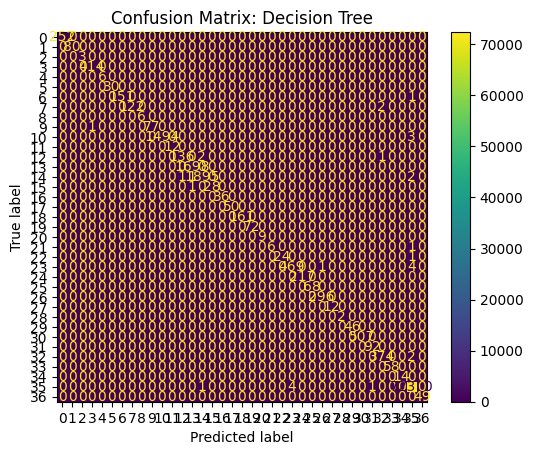

ROC curve is currently implemented only for binary classification.

=== k-NN (sampled) Evaluation ===
Accuracy: 0.9169
F1-score: 0.2707


c:\Users\bhawe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\bhawe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\bhawe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave


Classification Report:
                       precision    recall  f1-score   support

           Australia       0.35      0.23      0.28       252
             Austria       0.57      0.38      0.45        80
             Bahrain       0.00      0.00      0.00         3
             Belgium       0.51      0.32      0.39       414
              Brazil       0.00      0.00      0.00         6
              Canada       1.00      0.27      0.42        30
     Channel Islands       0.82      0.15      0.26       152
              Cyprus       0.74      0.37      0.49       124
      Czech Republic       0.00      0.00      0.00         6
             Denmark       0.57      0.36      0.44        78
                EIRE       0.70      0.22      0.34      1497
  European Community       0.00      0.00      0.00        12
             Finland       0.54      0.26      0.35       139
              France       0.49      0.39      0.44      1698
             Germany       0.58      0.40   

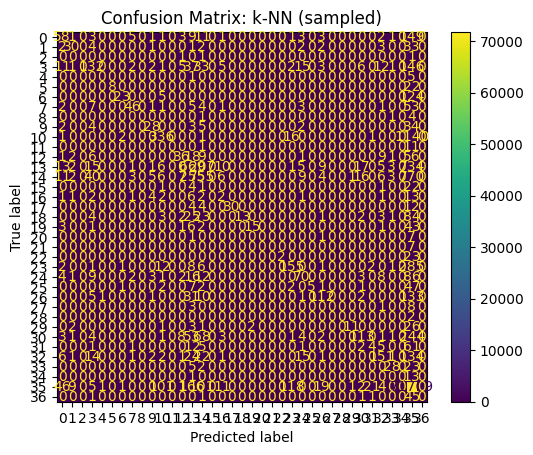

ROC curve is currently implemented only for binary classification.


,name,accuracy,f1
0,Decision Tree,0.999631,0.995263
1,k-NN (sampled),0.916857,0.270652


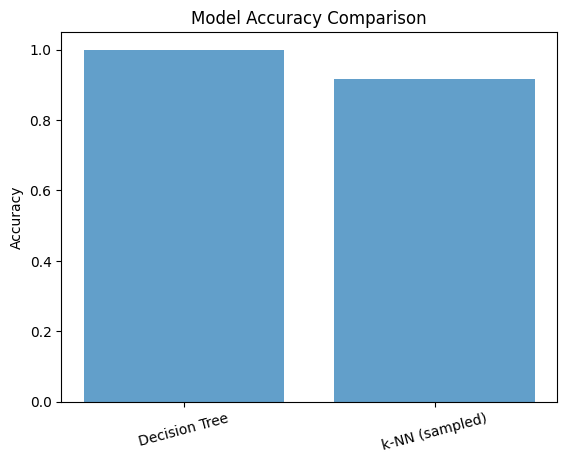

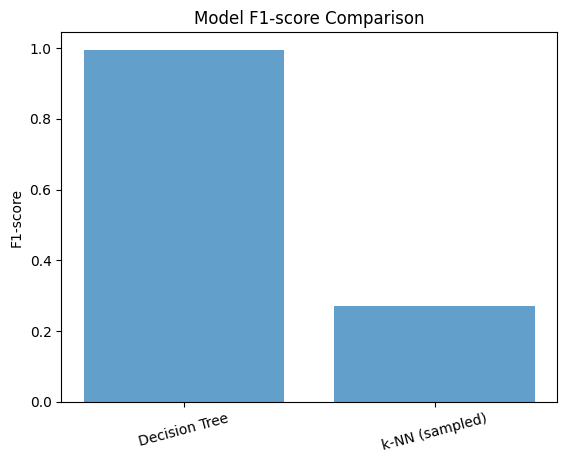

In [45]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix, classification_report,
    roc_curve, roc_auc_score
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Classification target column
TARGET_COL = "Country"              # better than CustomerID

RANDOM_STATE = 42
TEST_SIZE = 0.2  # 80/20 train/test split

# =========================
# 2. Preprocessing and Train/Test Split
# =========================

# 1) Ensure the target column exists
assert TARGET_COL in df.columns, f"TARGET_COL='{TARGET_COL}' not found in dataset columns."

# 2) Drop rows where the target is missing
df_clf = df.dropna(subset=[TARGET_COL]).copy()

# 3) Separate features and target
X = df_clf.drop(columns=[TARGET_COL])
y = df_clf[TARGET_COL]

# 4) Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

# 5) Force all categorical columns to string to avoid int/str mix in OneHotEncoder
for col in categorical_features:
    X[col] = X[col].astype(str)

# 6) Clean infinities and NaNs in features
X = X.replace([np.inf, -np.inf], np.nan)
X = X.dropna()

# 7) Align y with cleaned X
y = y.loc[X.index]

print("After cleaning, X shape:", X.shape)
print("After cleaning, y shape:", y.shape)

# 8) Preprocessing for numeric and categorical data
numeric_transformer = Pipeline(
    steps=[
        ("scaler", StandardScaler())
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

# 9) Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

# =========================
# 3. Helper: evaluate_classifier
# =========================

def evaluate_classifier(name, model, X_test, y_test):
    """Print metrics and plot confusion matrix + ROC (if applicable)."""
    from sklearn.metrics import ConfusionMatrixDisplay

    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="binary" if len(np.unique(y_test)) == 2 else "macro")
    
    print(f"\n=== {name} Evaluation ===")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1-score: {f1:.4f}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f"Confusion Matrix: {name}")
    plt.show()
    
    # ROC curve (binary only)
    if len(np.unique(y_test)) == 2:
        try:
            if hasattr(model, "predict_proba"):
                y_score = model.predict_proba(X_test)[:, 1]
            elif hasattr(model, "decision_function"):
                y_score = model.decision_function(X_test)
            else:
                print("Model has no decision_function or predict_proba; skipping ROC.")
                return

            fpr, tpr, _ = roc_curve(y_test, y_score)
            auc = roc_auc_score(y_test, y_score)
            plt.figure()
            plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.3f})")
            plt.plot([0, 1], [0, 1], linestyle="--")
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title(f"ROC Curve: {name}")
            plt.legend()
            plt.show()
        except Exception as e:
            print("Could not compute ROC curve:", e)
    else:
        print("ROC curve is currently implemented only for binary classification.")
    
    return {"name": name, "accuracy": acc, "f1": f1}

# =========================
# 4a. Decision Tree Classifier
# =========================

dt_clf = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

dt_clf.fit(X_train, y_train)
metrics_dt = evaluate_classifier("Decision Tree", dt_clf, X_test, y_test)

# Use a smaller subset for k-NN due to large dataset size
X_knn, _, y_knn, _ = train_test_split(
    X_train, y_train,
    train_size=10000,   # only 10,000 rows
    random_state=RANDOM_STATE,
    stratify=y_train
)

knn_clf = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", KNeighborsClassifier(n_neighbors=5))
    ]
)

knn_clf.fit(X_knn, y_knn)
metrics_knn = evaluate_classifier("k-NN (sampled)", knn_clf, X_test, y_test)

# =========================
# 5d. Compare Model Performance
# =========================

metrics_df = pd.DataFrame([metrics_dt, metrics_knn])
display(metrics_df)

plt.figure()
plt.bar(metrics_df["name"], metrics_df["accuracy"], alpha=0.7)
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.xticks(rotation=15)
plt.show()

plt.figure()
plt.bar(metrics_df["name"], metrics_df["f1"], alpha=0.7)
plt.ylabel("F1-score")
plt.title("Model F1-score Comparison")
plt.xticks(rotation=15)
plt.show()

## Clustering Analysis

This function compute

-K-Means (or DBSCAN / Hierarchical) setup

-Feature scaling for clustering

-Cluster assignment code

-Silhouette score

-Scatter plot or other visualization of clusters

Cluster label counts:
0    406826
2         2
1         1
Name: count, dtype: int64


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,cluster
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,0


c:\Users\bhawe\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


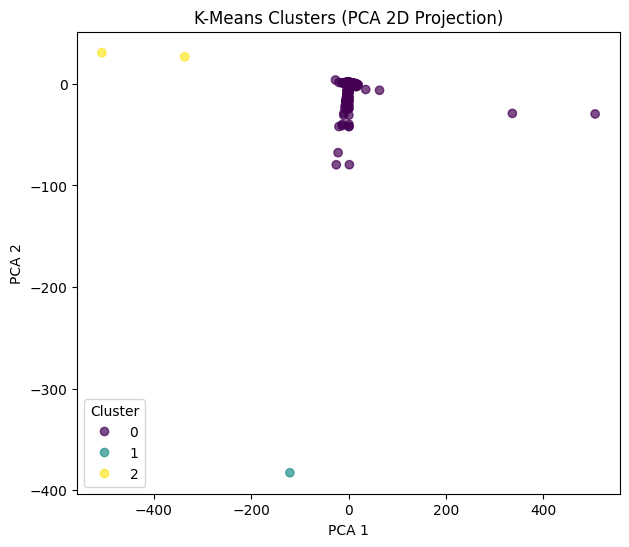

In [46]:
# =========================
# K-Means Clustering
# =========================

# Use the cleaned feature matrix X (no target) from preprocessing
X_preprocessed = preprocessor.fit_transform(X)

# Choose number of clusters (k)
k = 3  # or 4/5 if you want more groups
kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
cluster_labels = kmeans.fit_predict(X_preprocessed)

print("Cluster label counts:")
print(pd.Series(cluster_labels).value_counts())

# Add cluster labels back to the cleaned dataframe used for X
# (df_clf is the one after dropping missing TARGET_COL)
df_clusters = df_clf.loc[X.index].copy()
df_clusters["cluster"] = cluster_labels

display(df_clusters.head())

# =========================
#  PCA Visualization of Clusters
# =========================

pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_preprocessed)

plt.figure(figsize=(7, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, alpha=0.7)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("K-Means Clusters (PCA 2D Projection)")
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.show()


## Association Rule Mining (Apriori)

In this section we:

1. Create or load a **transactional dataset** (one-hot encoded item presence).  
2. Use **Apriori** to find frequent itemsets.  
3. Generate **association rules** (e.g., by confidence, lift).  
4. Inspect the strongest/most interesting rules.

📝 For the project, you should **replace or extend** the example transactional data below with your own domain-specific transactional dataset (e.g., purchases, clicks, feature combinations).

Original item count: 4223
Popular item count: 640
Reduced transactions shape: (24446, 640)
Sampled transactions shape: (5000, 640)


c:\Users\bhawe\AppData\Local\Programs\Python\Python312\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


Frequent itemsets:


,support,itemsets
199,0.0888,(WHITE HANGING HEART T-LIGHT HOLDER)
154,0.0878,(REGENCY CAKESTAND 3 TIER)
80,0.0866,(JUMBO BAG RED RETROSPOT)
125,0.0758,(PARTY BUNTING)
102,0.0674,(LUNCH BAG RED RETROSPOT)
...,...,...
250,0.0200,"(LUNCH BAG PINK POLKADOT, LUNCH BAG SUKI DESIGN )"
39,0.0200,(EDWARDIAN PARASOL NATURAL)
220,0.0200,"(JUMBO BAG PINK POLKADOT, JUMBO BAG BAROQUE B..."
227,0.0200,"(JUMBO BAG RED RETROSPOT, JUMBO BAG PINK VINTA..."


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
20,"(ROSES REGENCY TEACUP AND SAUCER , GREEN REGEN...",(PINK REGENCY TEACUP AND SAUCER),0.0346,0.0352,0.0244,0.705202,20.034157,1.0,0.023182,3.272753,0.984136,0.537445,0.694447,0.699192
22,(PINK REGENCY TEACUP AND SAUCER),"(ROSES REGENCY TEACUP AND SAUCER , GREEN REGEN...",0.0352,0.0346,0.0244,0.693182,20.034157,1.0,0.023182,3.146489,0.984748,0.537445,0.682185,0.699192
19,"(ROSES REGENCY TEACUP AND SAUCER , PINK REGENC...",(GREEN REGENCY TEACUP AND SAUCER),0.0278,0.0456,0.0244,0.877698,19.247760,1.0,0.023132,7.803624,0.975155,0.497959,0.871854,0.706393
5,(GARDENERS KNEELING PAD CUP OF TEA ),(GARDENERS KNEELING PAD KEEP CALM ),0.0324,0.0372,0.0230,0.709877,19.082703,1.0,0.021795,3.318587,0.979327,0.493562,0.698667,0.664078
4,(GARDENERS KNEELING PAD KEEP CALM ),(GARDENERS KNEELING PAD CUP OF TEA ),0.0372,0.0324,0.0230,0.618280,19.082703,1.0,0.021795,2.534839,0.984209,0.493562,0.605498,0.664078
3,(SPACEBOY LUNCH BOX ),(DOLLY GIRL LUNCH BOX),0.0376,0.0354,0.0244,0.648936,18.331530,1.0,0.023069,2.747648,0.982387,0.502058,0.636052,0.669101
2,(DOLLY GIRL LUNCH BOX),(SPACEBOY LUNCH BOX ),0.0354,0.0376,0.0244,0.689266,18.331530,1.0,0.023069,3.097178,0.980146,0.502058,0.677125,0.669101
21,"(GREEN REGENCY TEACUP AND SAUCER, PINK REGENCY...",(ROSES REGENCY TEACUP AND SAUCER ),0.0282,0.0480,0.0244,0.865248,18.026005,1.0,0.023046,7.064842,0.971933,0.471042,0.858454,0.686791
7,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.0352,0.0456,0.0282,0.801136,17.568780,1.0,0.026595,4.799269,0.977488,0.536122,0.791635,0.709779
6,(GREEN REGENCY TEACUP AND SAUCER),(PINK REGENCY TEACUP AND SAUCER),0.0456,0.0352,0.0282,0.618421,17.568780,1.0,0.026595,2.528441,0.988140,0.536122,0.604499,0.709779


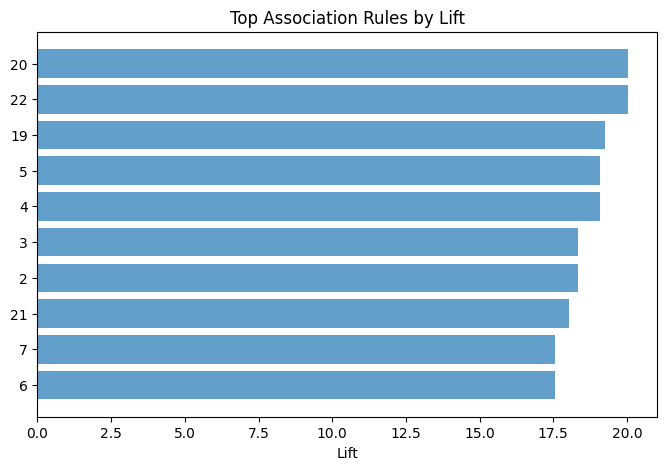

In [48]:
# -------------------------
# Reduce dimensionality before Apriori
# -------------------------

# 1) Compute item support (fraction of transactions containing each item)
item_support = transactions.mean(axis=0)  # each column's mean = support

# Keep only items that appear in at least 1% of transactions
popular_items = item_support[item_support >= 0.01].index
print("Original item count:", transactions.shape[1])
print("Popular item count:", len(popular_items))

transactions_reduced = transactions[popular_items]
print("Reduced transactions shape:", transactions_reduced.shape)

# Sample at most 5,000 transactions for association mining
transactions_sample = transactions_reduced.sample(
    n=min(5000, len(transactions_reduced)),
    random_state=42
)

print("Sampled transactions shape:", transactions_sample.shape)

from mlxtend.frequent_patterns import apriori

frequent_itemsets = apriori(
    transactions_sample,
    min_support=0.02,   # 2% of *sampled* transactions
    use_colnames=True
)

print("Frequent itemsets:")
display(frequent_itemsets.sort_values("support", ascending=False))

# =========================
# 6c. Association Rules
# =========================

rules = association_rules(
    frequent_itemsets,
    metric="confidence",  # can also use 'lift'
    min_threshold=0.6      # TODO: adjust based on your data
)

# Sort rules by lift
rules_sorted = rules.sort_values("lift", ascending=False)
display(rules_sorted.head(10))

# =========================
# 6d. Simple Visualization of Rule Strength (by Lift)
# =========================

top_rules = rules_sorted.head(10).copy()
plt.figure(figsize=(8, 5))
plt.barh(
    top_rules.index.astype(str),
    top_rules["lift"],
    alpha=0.7
)
plt.xlabel("Lift")
plt.title("Top Association Rules by Lift")
plt.gca().invert_yaxis()
plt.show()

## Insights and Practical Recommendations

- Summarize what you learned from regression, classification, clustering, and rules.
- Example:
  - Which customers are most valuable?
  - Which products are frequently bought together?
  - Which patterns suggest marketing or inventory actions?

##  Ethical Considerations

Discuss:
- Data privacy (e.g., customer identifiers)
- Potential bias in the dataset (e.g., only certain countries or time periods)
- How predictions might unfairly treat some users if misused
- Steps you took (or could take) to reduce bias and improve fairness

